## Census Data

Data : US Census 2010  [Download from S3](https://s3.amazonaws.com/datashader-data/census2010.parq.zip)  
Data from Census 2020 are not yet available.

Source : 
https://examples.pyviz.org/census/census.html



In [1]:
from IPython.core.display import HTML, display

import datashader as ds, datashader.transfer_functions as tf, numpy as np
from fastparquet import ParquetFile

In [2]:
pf = ParquetFile('data/census2010.parq')

In [3]:
df = pf.to_pandas()
print(len(df))
df.head()

306675004


,easting,northing,race
0,-12418767.0,3697425.00,h
1,-12418512.0,3697143.50,h
2,-12418245.0,3697584.50,h
3,-12417703.0,3697636.75,w
4,-12418120.0,3697129.25,h


----

In [4]:
from functools import partial
from datashader.utils import export_image

from datashader.utils import lnglat_to_meters as webm
USA           = ((-124.72,  -66.95), (23.55, 50.06))
plot_width  = int(1440)
plot_height = int(plot_width*7.0/12)


In [5]:
cvs = ds.Canvas(plot_width, plot_height, *webm(*USA))
agg = cvs.points(df, 'easting', 'northing')

In [6]:
violet = "#452392"
plum = "#A43A8F"
green = "#99C941"


def hex_to_RGB(hex):
    return [int(hex[i:i+2], 16) for i in range(1,6,2)]

def RGB_to_hex(RGB):
    RGB = [int(x) for x in RGB]
    return "#"+"".join(["0{0:x}".format(v) if v < 16 else
                        "{0:x}".format(v) for v in RGB])


def color_scale(from_hex, to_hex, n=10):
    
    from_rgb = hex_to_RGB(from_hex)
    to_rgb = hex_to_RGB(to_hex)
    
    result = [from_hex]

    for i in range(1, n):
        new_color = [
            int(from_rgb[j] + (float(i)/(n-1))*(to_rgb[j]-from_rgb[j]))
            for j in range(3)
        ]

        result.append( RGB_to_hex(new_color))

    return result

In [7]:
# branded colors from violet to plum then to green. Not used anymore.
#qs_colors = [ "#613EA3","#673EA1","#6D3D9F","#733D9E","#793D9C","#7F3C9A","#863C98","#8C3B96","#923B94","#983B93","#9E3A91","#A43A8F",    
#                "#A34788","#A25481","#A1617A","#A06E73","#9F7B6C","#9E8864","#9D955D","#9CA256","#9BAF4F","#9ABC48","#99C941", ]


# we generate 48 shades from one brand color to some white
# In the version from 2021 08 30, we used to keep only the 20 first shades but the result is too dark.
violet_shades = color_scale(violet, "#FFFFFF", 48)
plum_shades = color_scale(plum, "#FFFFFF", 48)
green_shades = color_scale(green, "#FFFFFF", 48)

# Let's make the green scale have a gap to distinguish better the dark and light areas
green_shades = green_shades[0:30] + green_shades[40:]

In [8]:
for k in green_shades:
    display(HTML(f'''<div style="width:30px;height:30px;background-color:{k};display:inline;float:left;margin-right:10px;">&nbsp;</div>{k}'''))


In [12]:
def make_plot(agg, color_shades, bg_color="black"):
    plot = tf.shade(agg, cmap = color_shades, how='eq_hist')
    plot = tf.set_background(plot, bg_color)
    return plot


violet_plot = make_plot(agg, violet_shades)
plum_plot = make_plot(agg, plum_shades)
green_plot = make_plot(agg, green_shades)

In [13]:
export_fn = partial(export_image, background = 'black', export_path="export")

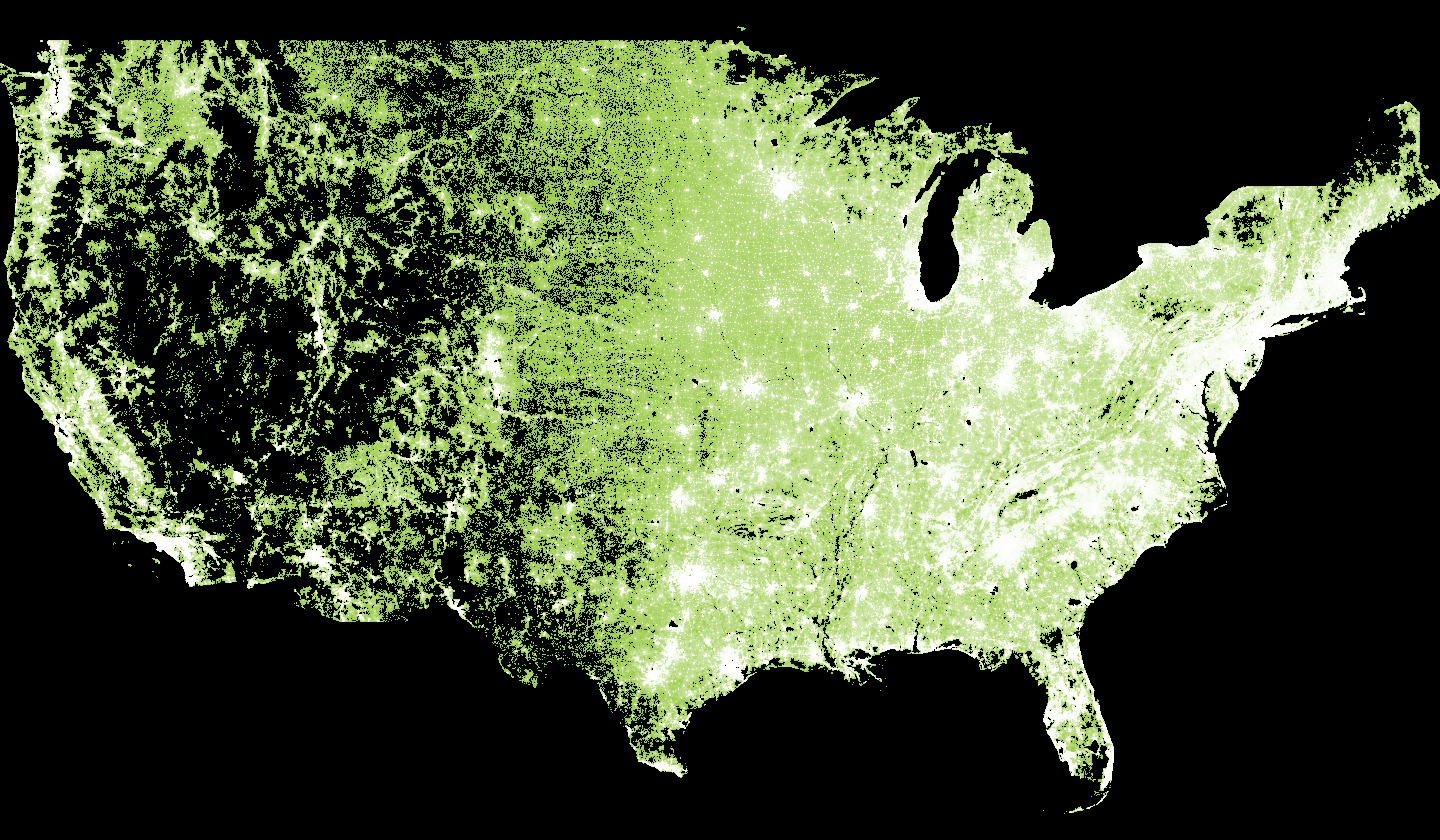

In [14]:
export_fn(violet_plot,"cencus_violet")
export_fn(plum_plot,"cencus_plum")
export_fn(green_plot,"cencus_green")
